# **Import library and Mount drive**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

import librosa
import os
import librosa.display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Take sound data from folder**

In [3]:
main_dir = '/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24'

In [4]:
def label_from_folder(file_name):
    string = file_name
    # Split the string by hyphen
    numbers = string.split('-')
    # Access the third number (index 2)
    third_number = numbers[2]

    if '01' in third_number:
        return 'Neutral'
    elif '02' in third_number:
        return 'Calm'
    elif '03' in third_number:
        return 'Happy'
    elif '04' in third_number:
        return 'Sad'
    elif '05' in third_number:
        return 'Angry'
    elif '06' in third_number:
        return 'Fearful'
    elif '07' in third_number:
        return 'Disgust'
    elif '08' in third_number:
        return 'Surprised'
    else:
        return 'Unknown'

# Dictionary to store file paths and their corresponding labels
data = {'file_path': [], 'label': []}

# Iterate through each subfolder
for folder_name in os.listdir(main_dir):
    folder_path = os.path.join(main_dir, folder_name)
    # Iterate through each audio file in the subfolder
    for file_name in os.listdir(folder_path):
      if file_name.endswith('.wav') or file_name.endswith('.mp3'):
        label = label_from_folder(file_name)
        file_path = os.path.join(folder_path, file_name)
        data['file_path'].append(file_path)
        data['label'].append(label)

# Convert to DataFrame
df = pd.DataFrame(data)

In [5]:
df

,file_path,label
0,/content/drive/MyDrive/Sound_Expression/audio_...,Neutral
1,/content/drive/MyDrive/Sound_Expression/audio_...,Calm
2,/content/drive/MyDrive/Sound_Expression/audio_...,Neutral
3,/content/drive/MyDrive/Sound_Expression/audio_...,Calm
4,/content/drive/MyDrive/Sound_Expression/audio_...,Calm
...,...,...
1435,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1436,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1437,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1438,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised


# **Save output CSV to folder And Plot example**

In [ ]:
output_file_path = '/content/drive/MyDrive/Sound_Expression/audio_labels.csv'
df.to_csv(output_file_path, index=False)

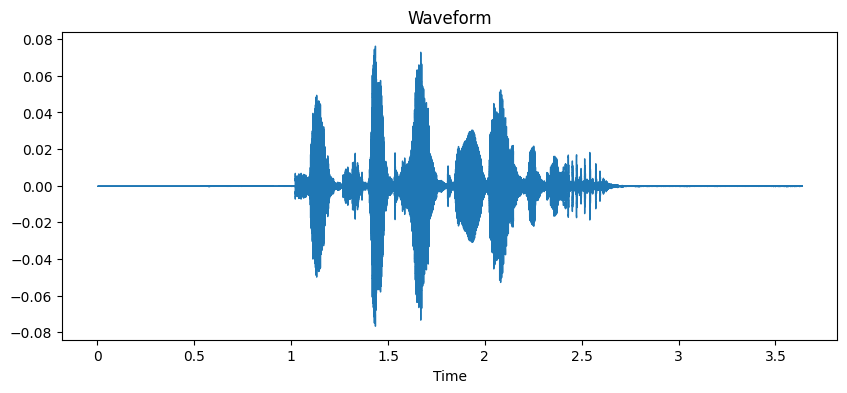

<ipython-input-6-efbc979e0c04>:12: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


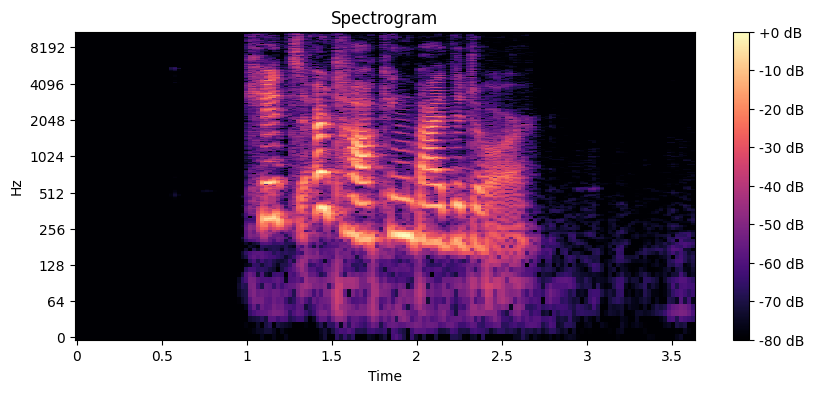

In [6]:
# Load an example audio file
example_file = os.path.join(main_dir, '/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-01-02.wav')
y, sr = librosa.load(example_file)

# Display waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

# Display spectrogram
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

# **Data Extraction**

In [9]:
# Function to extract MFCC features from an audio file
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # Extract delta and delta-delta coefficients
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
    return mfccs, mfcc_delta, mfcc_delta2

In [10]:
def pad_or_truncate(features, max_length):
    if features.shape[1] > max_length:
        return features[:, :max_length]
    elif features.shape[1] < max_length:
        pad_width = max_length - features.shape[1]
        return np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
    else:
        return features

# Function to flatten MFCC, delta, and delta-delta features
def flatten_features(mfccs, mfcc_delta, mfcc_delta2, max_length):
    # Pad or truncate each feature set to the fixed length
    mfccs_padded = pad_or_truncate(mfccs, max_length)
    mfcc_delta_padded = pad_or_truncate(mfcc_delta, max_length)
    mfcc_delta2_padded = pad_or_truncate(mfcc_delta2, max_length)

    # Concatenate and flatten the features
    combined_features = np.concatenate((mfccs_padded, mfcc_delta_padded, mfcc_delta2_padded), axis=0)
    flattened_features = combined_features.flatten()
    return flattened_features

In [11]:
output_file_path = '/content/drive/MyDrive/Sound_Expression/features_extraction.csv'
df.to_csv(output_file_path, index=False)

In [12]:
def extract_features_to_csv(file_paths, labels, output_csv, n_mfcc=13, max_length=17000):
    with open(output_csv, 'w') as f:
        # Write header
        header = ['File'] + [f'Feature_{i}' for i in range(max_length)] + ['Label']
        f.write(','.join(header) + '\n')

        for i, file_path in enumerate(file_paths):
            # Extract features
            mfccs, mfcc_delta, mfcc_delta2 = extract_mfcc(file_path, n_mfcc=n_mfcc)
            flattened_features = flatten_features(mfccs, mfcc_delta, mfcc_delta2, max_length=max_length)
            label = labels[i]

            # Write row
            row = [f'File_{i}'] + flattened_features.tolist() + [label]
            f.write(','.join(map(str, row)) + '\n')

# Example usage
file_paths = df.iloc[:, 0].values
labels = df.iloc[:, -1].values
output_csv = '/content/drive/MyDrive/Sound_Expression/features_extraction.csv'
extract_features_to_csv(file_paths, labels, output_csv, n_mfcc=13, max_length=17000)

# **Others Features we can considered when the model are not satisfy**

# Extract chroma features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Extract spectral contrast
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# Extract spectral centroid
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

# Extract zero-crossing rate
zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

# Extract root mean square energy
rms = librosa.feature.rms(y=y)

# Extract mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)


In [ ]:
# # Load audio file
# y, sr = librosa.load('your_audio_file.wav', sr=None)

# # Extract MFCCs
# mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# # Extract delta and delta-delta coefficients
# mfcc_delta = librosa.feature.delta(mfcc)
# mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

# # Extract chroma features
# chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# # Extract spectral contrast
# spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# # Extract spectral centroid
# spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

# # Extract zero-crossing rate
# zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

# # Extract root mean square energy
# rms = librosa.feature.rms(y=y)

# # Extract mel spectrogram
# mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# # Combine all features
# features = np.concatenate((mfcc, mfcc_delta, mfcc_delta2, chroma, spectral_contrast,
#                            spectral_centroid, zero_crossing_rate, rms, mel_spectrogram), axis=0)

# # Shape of features
# print("Shape of combined features: ", features.shape)